# Summary

Simnge unit example. In the manuscript: **Fig. 3B**.

---
# Setup

In [1]:
# imports
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

from popy.io_tools import load_behavior, load_neural_data
from popy.behavior_data_tools import add_foraging_value
from popy.neural_data_tools import remove_trunctuated_neurons, add_firing_rates, downsample_time, build_trial_dataset, merge_behavior
from popy.config import COLORS, value_gradient

# fontsizes 8
plt.rcParams.update({'font.size': 8})


In [2]:
# local functions
def get_data(monkey, session):
    # get behavior data
    behav = load_behavior(monkey, session)

    behav = add_foraging_value(behav, digitize=True, n_classes=4) # add value function
    behav.dropna(subset=['stay_value'])  # drop nans in value (i.e., interrupted trials)
    
    # get neural data
    neural_data = load_neural_data(monkey, session, hz=1000)  # load neural data
    neural_data = remove_trunctuated_neurons(neural_data, mode='set_nan')  # set indices to nan
    neural_data = add_firing_rates(neural_data, 'gauss')  # add firing gauss
    neural_data = downsample_time(neural_data, 100)  # downsample neural data
    
    # build dataset    
    neural_dataset = build_trial_dataset(neural_data, mode='centering', center_on_epoch_start=5, center_window=(-3, 3))
    neural_dataset = merge_behavior(neural_dataset, behav)  # merge behavior and neural data

    return neural_data, neural_dataset
    
def plot_spike_trains(neural_data, monkey, session):
    plt.imshow(neural_data.spike_trains, aspect='auto', cmap='Grays', interpolation='none')
    ylabel = [f'{unit}' for unit in neural_data.unit.values]
    xlabel = neural_data.time.values
    plt.yticks(np.arange(len(ylabel)), ylabel, fontsize=5)
    #plt.xticks(np.arange(0, len(xlabel), 100000), xlabel[::100000])

    # add lables and legend: white horizontal bar is no recording, black is recording
    plt.plot([0, 0], [0, 0], color='black', label='Recording', linewidth=5)
    plt.plot([0, 0], [0, 0], color='white', label='No recording', linewidth=5)
    plt.legend(loc='upper right')

    plt.grid(alpha=.2)

    plt.xlabel('Time (ms)')
    plt.ylabel('Neurons')
    plt.title(f'{monkey}_{session}')
    plt.show()

def plot_rates_with_raster(
    neural_data_original, 
    suptitle=None,
    paper_format=False,  # use paper format
    ):    

    neural_data = neural_data_original.copy()

    # get the coord names of interest and determine the number of plots to make
    coord_names = ['feedback', 'stay_value']  # get the coord names of interest
    n_plots = 2
    
    # Create figure and axes with no space between rows
    if paper_format:
        # fontsize 8
        plt.rcParams.update({'font.size': 8})  # set fontsize to 8
        h, w = 1, 1.5 * n_plots  # 3 cm height, 3 cm width per plot
        fig = plt.figure(figsize=(w, h))
    else:
        h, w = 3, 3*n_plots
        fig = plt.figure(figsize=(w, h))
    
    gs = fig.add_gridspec(2, n_plots, height_ratios=[1, .7], hspace=0)

    # Create axes arrays with shared axes
    axs = [[None for j in range(n_plots)] for i in range(2)]
    
    # First create the leftmost column
    axs[0][0] = fig.add_subplot(gs[0, 0])  # Top left
    axs[1][0] = fig.add_subplot(gs[1, 0])  # Bottom left
    plt.setp(axs[0][0].get_xticklabels(), visible=False)  # Hide only the tick labels, keep ticks

    # Then create the rest sharing both x and y axes
    for j in range(1, n_plots):
        axs[0][j] = fig.add_subplot(gs[0, j], sharey=axs[0][0])  # Top row
        axs[1][j] = fig.add_subplot(gs[1, j], sharey=axs[1][0])  # Bottom row
        plt.setp(axs[0][j].get_xticklabels(), visible=False)  # Hide only the tick labels, keep ticks

    if not suptitle is None:
        fig.suptitle(suptitle, style='italic')

    for i, coord_name in enumerate(coord_names):
        # get the variable and the conditions
        variable = coord_name

        unique_labels = np.unique(neural_data[coord_name].data)  # get the unique labels of all of the coords of interest
        unique_labels = unique_labels[~np.isnan(unique_labels)]  # remove nans
        
        if variable == 'feedback':
            COLORS_temp = COLORS
            label_encoding = {0: 'Unrewarded', 1: 'Rewarded'}  # encode the feedback labels
            time_window=(-.5, 2)
            legend_title='Feedback'
        elif variable == 'stay_value':
            COLORS_temp = value_gradient(len(unique_labels))
            label_encoding = {0:'<25%', 1:'25-50%', 2:'50-75%', 3:'>75%'}
            time_window=(-2, .5)
            legend_title='Value level'

        colors = {str(label): COLORS_temp[i] for i, label in enumerate(unique_labels)}  # color for each value level

        # prepare the data (sort trials by the coord_name, drop trials with nan labels)
        neural_data_temp = _prepare_data(neural_data, coord_name)

        time_vector = neural_data_temp.coords['time'].data  # get the time vector and the trial labels

        # plot raster with extent of x=time_vector and y=trial_labels
        ax_raster = axs[0][i]

        # Plot colored spikes
        # Convert spike trains to x,y coordinates
        spikes = np.where(neural_data_temp.spike_trains)
        trial_ids = spikes[0]
        spike_times = time_vector[spikes[1]]

        # Get colors for each spike based on trial type
        trial_colors = [colors[str(neural_data_temp[coord_name].sel(trial_id=neural_data_temp.trial_id.data[tid]).data)] for tid in trial_ids]  # get the color of the trial

        ax_raster.scatter(spike_times, trial_ids, marker='|', c=trial_colors, s=2.5, linewidth=0.6)
        
        ax_raster.set_ylabel('')
        
        ax_raster.set_yticks([])  # remove y ticks
        #ax_raster.legend(title=f'{coord_name.split("--")[0][1:]}', loc='center left', bbox_to_anchor=(1, 0.5))
        ax_raster.spines['bottom'].set_visible(False)

        # plot firing rate (that is the mean spike count) by value level
        ax_rate = axs[1][i]
        unique_labels_temp = np.unique(neural_data_temp[coord_name].data)  # set background color based on value level
        for label_temp in unique_labels_temp:
            curr_coord_ids = np.where(neural_data_temp[coord_name].data == label_temp)[0]  # get the non-nan indices
            curr_coord_trials = neural_data_temp.trial_id.data[curr_coord_ids]
            neural_data_currvalue = neural_data_temp.sel({'trial_id': curr_coord_trials})  # further select only the interesting units
            # rolling window spike count mean
            mean_rate = np.mean(neural_data_currvalue.firing_rates, axis=0)

            ax_rate.plot(time_vector, mean_rate, label=label_temp if label_encoding is None else label_encoding[label_temp], color=colors[str(label_temp)])
            
        if not paper_format:
            ax_rate.set_ylabel('Firing rate (Hz)')
            ax_rate.set_xlabel('Time from feedback (s)')
            # legend outside the plot
            ax_rate.legend(title=variable if legend_title is None else legend_title, frameon=False, loc='center left', bbox_to_anchor=(1, 0.5))
        # settings
        for ax in [ax_raster, ax_rate]:
            ax.axvline(0, color='black', lw=.7)  # plot the centering line
            ax.set_xlim(*time_window)
            # remove spines
            for spine in ['right', 'top']:
                ax.spines[spine].set_visible(False)

    if not paper_format:    
        plt.tight_layout()

    return fig, axs

def _prepare_data(neural_data, coord_name):
        neural_data_temp = neural_data.copy()
        
        # get only the trials where the coord_name is not nan, and sort them
        non_nan_coord_ids = np.where(~np.isnan(neural_data_temp[coord_name].data))[0]  # get the non-nan indices
        non_nan_coord_trials = neural_data_temp.trial_id.data[non_nan_coord_ids]  # get the non-nan trials
        non_nan_coord_labels = neural_data_temp[coord_name].data[non_nan_coord_ids]  # get the non-nan labels
        non_nan_coord_trials = non_nan_coord_trials[np.argsort(non_nan_coord_labels)]  # sort the trials by the labels
        neural_data_temp = neural_data_temp.sel({'trial_id': non_nan_coord_trials})  # remove nan values (nan coordinates) and sort the trials by the labels

    
        return neural_data_temp

---
# Load data

In [3]:
monkey, session = 'ka', '210322'  # example session

# get data (load behavior, compute value function, load spikes, convert to firing rates, build trial dataset, merge with behavioral data)
neural_data, neural_dataset = get_data(monkey, session)
neural_dataset

<xarray.Dataset>
Dimensions:           (unit: 47, trial_id: 425, time: 600)
Coordinates: (12/17)
  * unit              (unit) object 'LPFC_03_03' 'LPFC_03_01' ... 'MCC_16_01'
    unit_id_original  (unit) int64 67 65 66 8 68 9 16 ... 48 49 53 52 61 59 58
    channel           (unit) int64 3 3 3 4 4 4 5 5 6 ... 12 12 13 13 14 16 16 16
    monkey            (unit) object 'ka' 'ka' 'ka' 'ka' ... 'ka' 'ka' 'ka' 'ka'
    session           (unit) object '210322' '210322' ... '210322' '210322'
    area              (unit) object 'LPFC' 'LPFC' 'LPFC' ... 'MCC' 'MCC' 'MCC'
    ...                ...
    best_target       (trial_id) int64 1 1 1 1 1 1 1 1 1 1 ... 3 3 3 3 3 3 3 3 3
    target            (trial_id) float64 2.0 3.0 1.0 1.0 3.0 ... 3.0 3.0 3.0 2.0
    feedback          (trial_id) float64 0.0 0.0 1.0 0.0 0.0 ... 0.0 0.0 0.0 1.0
    switch            (trial_id) float64 nan 1.0 1.0 0.0 1.0 ... 0.0 0.0 0.0 1.0
    stay_value        (trial_id) int64 0 0 0 1 1 0 1 1 0 0 ... 2 3 1 2 3 3 2 1 0
    V0                (trial_id) float64 0.1183 0.1183 0.1183 ... 0.1183 0.1183
Data variables:
    spike_trains      (trial_id, unit, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    firing_rates      (trial_id, unit, time) float32 0.0 0.0 ... 0.1092 0.1923
Attributes:
    bin_size:  0.01

---
# Plot raster by value level as condition

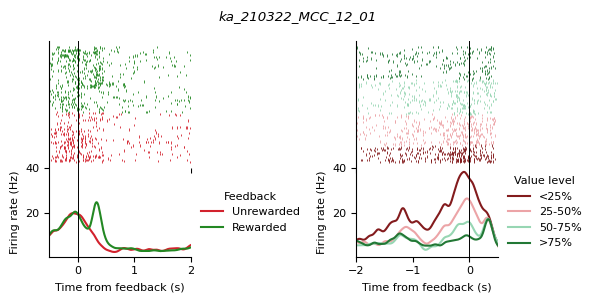

In [4]:
# show an example unit
unit_name = 'MCC_12_01'  # get the first unit as an example

title = f'{neural_data.coords["monkey"].data[0]}_{neural_data.coords["session"].data[0]}_{unit_name}'

fig, axs = plot_rates_with_raster(
    neural_dataset.sel({'unit': unit_name}), 
    suptitle=title,
    )
    
plt.show()
